# $\textit{Predicción lineal}$
$\textit{By Agustín Luís Gullino - Gonzalo Ezequiel Linares}$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as sp
import scipy.io as io
import helper as hp
import importlib
from numpy.fft import fft, rfft
from numpy.fft import fftshift, fftfreq, rfftfreq
from IPython.display import Audio
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
%load_ext autoreload
%autoreload 2
%matplotlib widget

# $\textit{1)}$

Se tomaron grabaciones de voz de ambos sonidos como fue pedido. Para asegurar el uso de prediccion estacionaria se realizo un test de estacionaridad para verificar esto, y los resultados observados permiten concluir que la señal es estacionaria con un alto grado de confianza. Posterior a esto, se resto la media de la señal como precaucion para evitar que se vea afectada por los filtros. De todas formas, en aplicaciones de audio la media no es util. Tambien se realizo un analisis de las señales, graficandolas en el tiempo, observando una estimacion de su PSD, y tambien una estimacion de su autocorrelacion. En los siguientes puntos se utilizaran estos elementos para entender los resultados

In [2]:
fss, signal, path = hp.getRecordedSignals()

/home/gullino18/Documents/Github/PASA_TP3/helper.py:20: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs1, aSignal = io.wavfile.read(path[0])
/home/gullino18/Documents/Github/PASA_TP3/helper.py:21: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs2, shSignal = io.wavfile.read(path[1])


In [3]:
hp.play(signal=signal["a"], fs=fss["a"])

In [4]:
from arch.unitroot import ADF
from arch.unitroot import PhillipsPerron

''' 
Para el test, se tiene en cuenta que las hipotesis son:

H0: La serie contiene raiz unitaria.
H1: La serie es estacionaria.

Si el p-valor esta por encima del critico, la hipotesis nula no puede ser rechazada, indicando que 
la serie no es estacionaria.
'''

norm1 = signal["a"]
norm2 = signal["sh"]
max_lags_test=len(signal["a"])//10

adf = ADF(norm1, max_lags=max_lags_test)
print(adf.summary().as_text())
print("Dado que P-value = 0, podemos concluir que la señal de aaa es estacionaria.")
print('\n//////////////////////////////////////\n')

adf = ADF(norm2, max_lags=max_lags_test)
print(adf.summary().as_text())
print("Dado que P-value = 0, podemos concluir que la señal de shh estacionaria.")

pp = PhillipsPerron(norm1)
print(pp.summary().as_text())
print("Dado que P-value = 0, podemos concluir que la señal de aaa estacionaria.")
print('\n//////////////////////////////////////\n')

pp = PhillipsPerron(norm2)
print(pp.summary().as_text())
print("Dado que P-value = 0, podemos concluir que la señal de shh estacionaria.")

   Augmented Dickey-Fuller Results   
Test Statistic                 -4.030
P-value                         0.001
Lags                              538
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
Dado que P-value = 0, podemos concluir que la señal de aaa es estacionaria.

//////////////////////////////////////

   Augmented Dickey-Fuller Results   
Test Statistic                -13.106
P-value                         0.000
Lags                              164
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
Dado que P-value = 0, podemos concluir que la señal de shh estacionaria.
     Phillips-Perron Test (Z-tau)    
Test Statistic                -12.

In [5]:
signal["a"] -= np.mean(signal["a"])
signal["sh"] -= np.mean(signal["sh"])

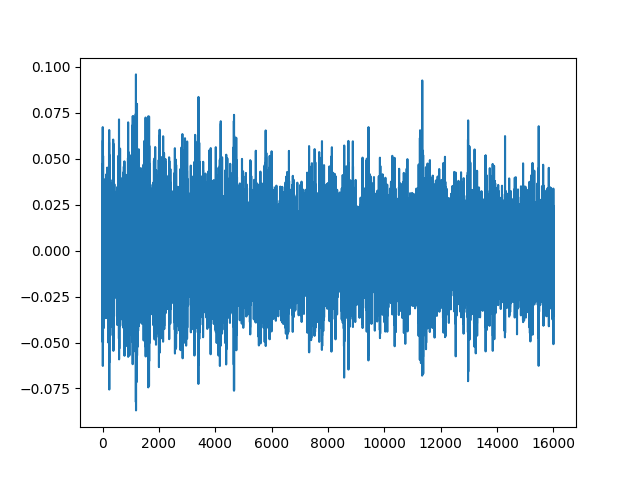

In [6]:
plt.figure()
plt.plot(signal["sh"])

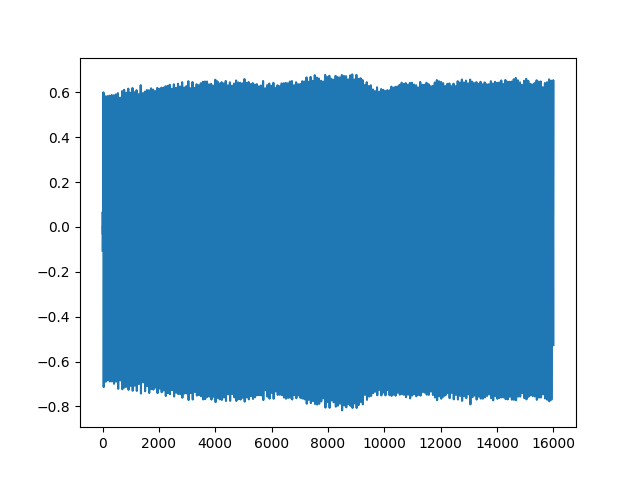

In [7]:
plt.figure()
plt.plot(signal["a"])

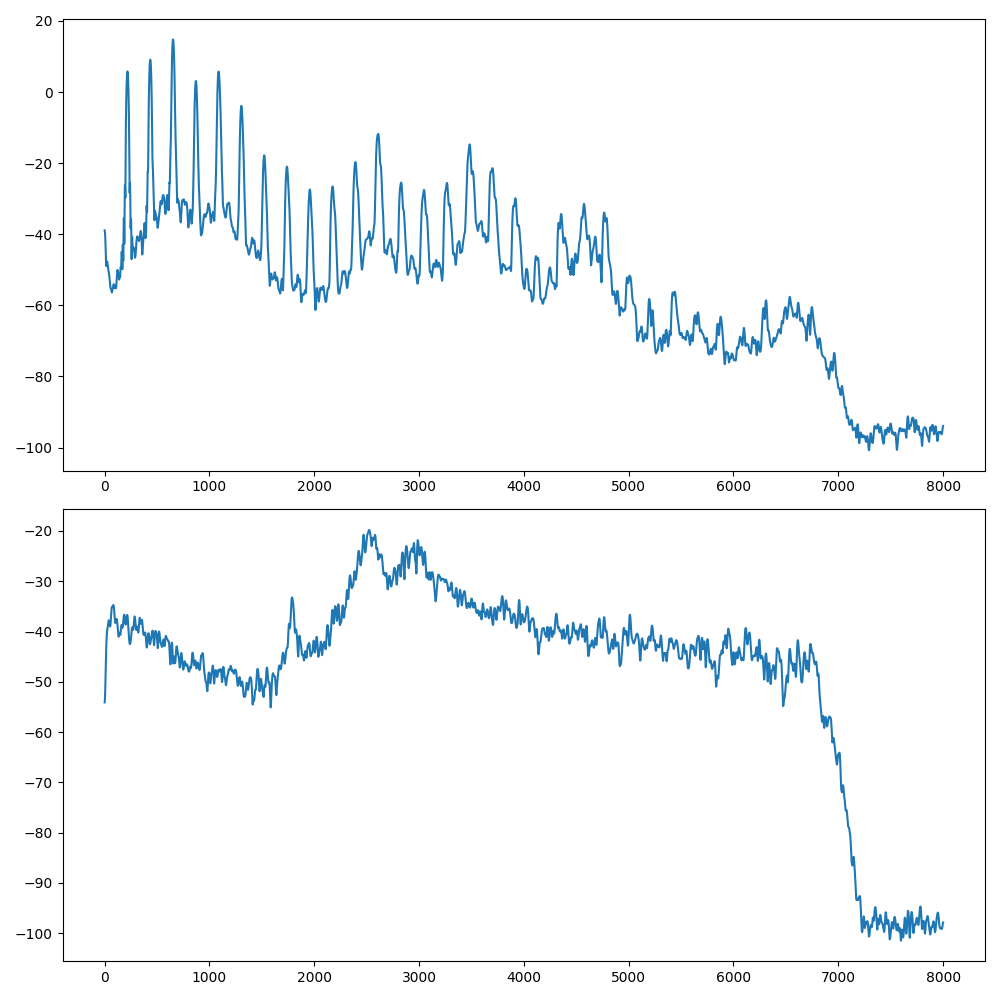

In [8]:
plt.figure(tight_layout=True, figsize=(10, 10))
plt.subplot(211)
freq, psd, L = hp.periodogram_averaging(signal["a"], fss['a'], len(signal["a"])//10, 8, lambda N: sp.get_window('hann', N))
A = 10*np.log10(psd+1e-18)
plt.plot(freq, A)

plt.subplot(212)
freq, psd, L = hp.periodogram_averaging(signal["sh"], fss['sh'], len(signal["sh"])//10, 8, lambda N: sp.get_window('hann', N))
A = 10*np.log10(psd+1e-18)
plt.plot(freq, A)

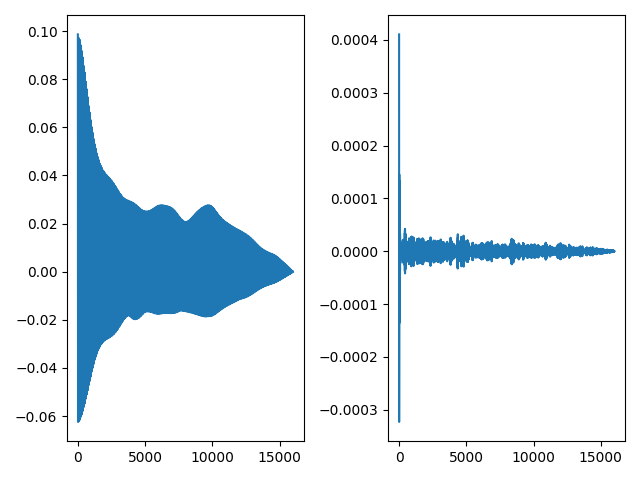

In [9]:
lags = sp.correlation_lags(len(signal["a"]), len(signal["a"]))
N = len(signal["a"])
rxa = sp.correlate(signal["a"], signal["a"])/N
rxsh = sp.correlate(signal["sh"], signal["sh"])/N

plt.figure(tight_layout=True)
plt.subplot(121)
plt.plot(lags[lags >= 0], rxa[lags >= 0])
plt.subplot(122)
plt.plot(lags[lags >= 0], rxsh[lags >= 0])


# $\textit{2)}$

Calculando y graficando Jo(M), se peuden observar 2 codos para /a/ y 1 codo para /sh/.
En el caso de /a/, se observo que el error rapidamente desciende hasta encontrar el primer codo en aproximadamente M=15. Y luego se estabiliza para nuevamente decrementar. Este primer codo indica que los primeros coeficientes aportan un gran valor a la prediccion de /a/, pero si se observa la señal error y la señal /a/, se puede ver que existen grandes picos separados por aproximadamente 70 muestras, que aportan energia en la señal error y no son modelados por nuestro predictor. Por estos picos es que nuestro error encuentra un nuevo codo en approx M=70. Al agregar el retardo 70, nuestro filtro ya puede capturar ese detalle y agregarlo en el modelo del predictor, capturando la energia que esto implica y disminuyendo asi el error.

En el caso de /sh/, esta señal no presenta una correlacion fuerte para lags lejanos, por lo que existe un unico codo y ocurre en M=20 aproximadamente. Si se observa con detalle el grafico del error para distintos M, se puede observar que para orden 16 en adelante no se nota un cambio apreciable en la señal de error, apoyando lo concluido anteriormente. 

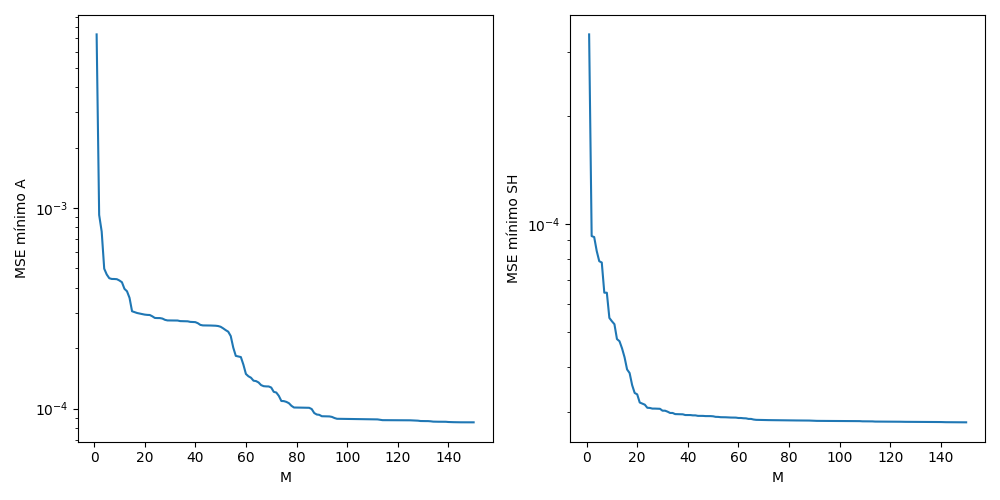

In [10]:
Ms = np.linspace(1, 150, 150, dtype=int)
wo_a = np.zeros((len(Ms)), dtype=np.ndarray)
wo_sh = np.zeros((len(Ms)), dtype=np.ndarray)
a_a = np.zeros((len(Ms)), dtype=np.ndarray)
a_sh = np.zeros((len(Ms)), dtype=np.ndarray)
jos_a = np.zeros(len(Ms))
jos_sh = np.zeros(len(Ms))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), tight_layout=True)

for i, M in enumerate(Ms):
    wo, jo, NMSE = hp.get_optimal_params(signal["a"], M)
    jos_a[i] = jo
    a_a[i] = np.insert(-wo, 0, 1) 
    wo_a[i] = wo

    wo, jo, NMSE = hp.get_optimal_params(signal["sh"], M)
    wo_sh[i] = wo
    jos_sh[i] = jo
    a_sh[i] = np.insert(-wo, 0, 1) 

axs[0].set_xlabel('M')
axs[0].set_ylabel('MSE mínimo A')
axs[0].plot(Ms, jos_a)
axs[0].set_yscale('log')

axs[1].set_xlabel('M')
axs[1].set_ylabel('MSE mínimo SH')
axs[1].plot(Ms, jos_sh)
axs[1].set_yscale('log')


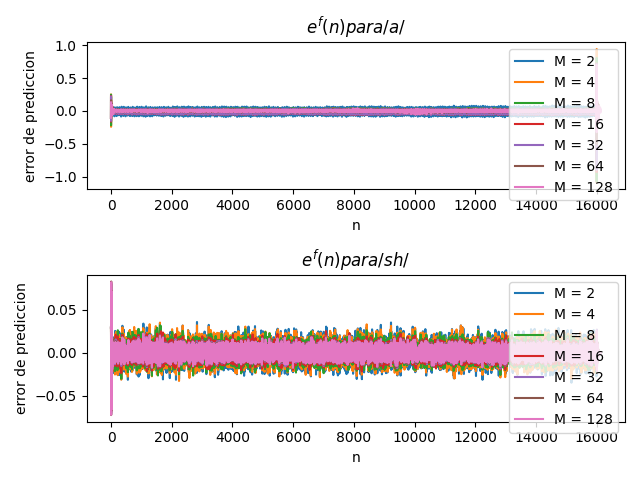

In [23]:

plt.figure(tight_layout=True)
plt.subplot(211)

for i in np.logspace(start=1, stop=7, num=7, base=2, endpoint=True, dtype=int):
    N = len(a_a[i])
    e_foa = np.convolve(a_a[i], signal["a"])
    plt.plot(e_foa, label=f'M = {i}')

plt.title("$e^f(n) para /a/$")
plt.xlabel("n")
plt.ylabel("error de prediccion")
plt.legend()

plt.subplot(212)
for i in np.logspace(start=1, stop=7, num=7, base=2, endpoint=True, dtype=int):
    N = len(a_sh[i])
    e_fosh = np.convolve(a_sh[i], signal["sh"])
    plt.plot(e_fosh, label=f'M = {i}')

plt.title("$e^f(n) para /sh/$")
plt.xlabel("n")
plt.ylabel("error de prediccion")
plt.legend()


# $\textit{3)}$

Si se observa la respuesta del filtro de error de ambas señales con el espectro de potencia estimado en el punto 1, se puede ver que para ordenes crecientes, las respuestas de los filtros convergen a la transformacion inversa de la señal de entrada, en otras palabras, convergen al filtro blanqueador. Si se observa la estimacion de la PSD del error de salida, se puede ver que para el caso de /a/, mientras mas se incrementa el orden del filtro, mas se reducen los picos de armonicos, y mas se "aplana" el espectro. Es importante observar que la energia de los picos disminuyo muy poco para orden M=64 comparado con lo anterior, lo que muestra nuevamente que se requieren ordenes mayores para mejorar. Observar que los picos se encuentran en aprox 216 Hz, y 16000Hz / 216Hz = 74, lo que nuevamente indica el motivo del segundo codo.
En el caso de /sh/ para M=16 ya se puede ver un espectro mas plano en comparacion a ordenes menores, y en los ordenes crecientes se ven mejoras poco significativas, lo cual indica nuevmanete porque existe un codo cerca de M=20.

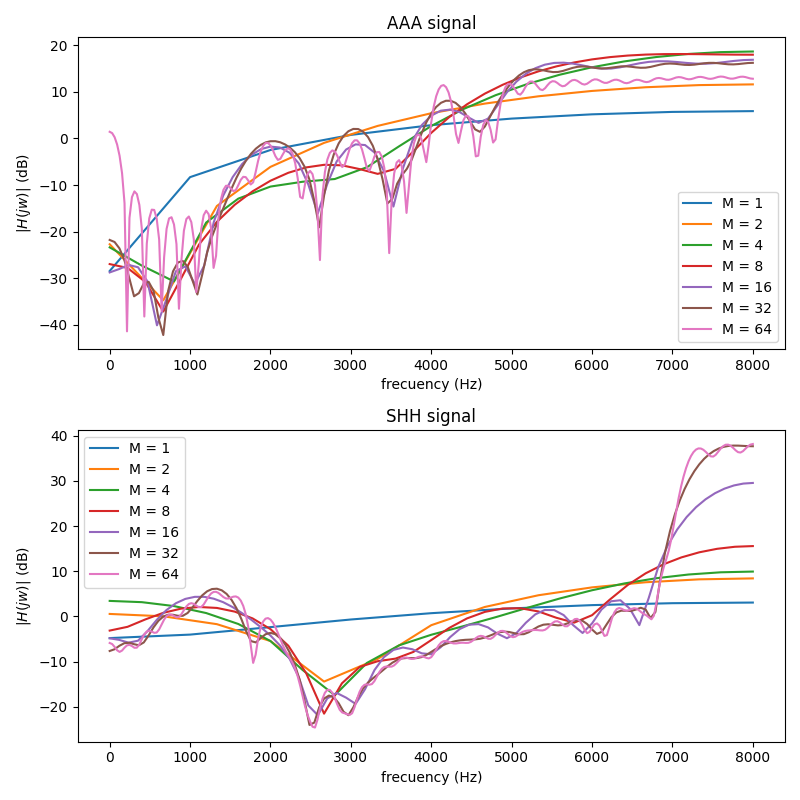

In [12]:
plt.figure(tight_layout=True, figsize=(8, 8))
plt.subplot(211)
for i in np.logspace(0, 6, 7, endpoint=True, base=2, dtype=int):
    N = len(a_a[i-1])
    freq = rfftfreq(N*8, 1/fss["a"])
    Hejw = rfft(a_a[i-1], N*8)
    A = 20*np.log10((np.abs(Hejw)+1e-18))
    plt.plot(freq, A, label=f'M = {i}')

plt.title("AAA signal")
plt.xlabel("frecuency (Hz)")
plt.ylabel("$|H(jw)|$ (dB)")
plt.legend()

plt.subplot(212)
for i in np.logspace(0, 6, 7, endpoint=True, base=2, dtype=int):
    N = len(a_sh[i-1])
    freq = rfftfreq(N*8, 1/fss["sh"])
    Hejw = rfft(a_sh[i-1], N*8)
    A = 20*np.log10((np.abs(Hejw)+1e-18))
    plt.plot(freq, A, label=f'M = {i}')

plt.title("SHH signal")
plt.xlabel("frecuency (Hz)")
plt.ylabel("$|H(jw)|$ (dB)")
plt.legend()

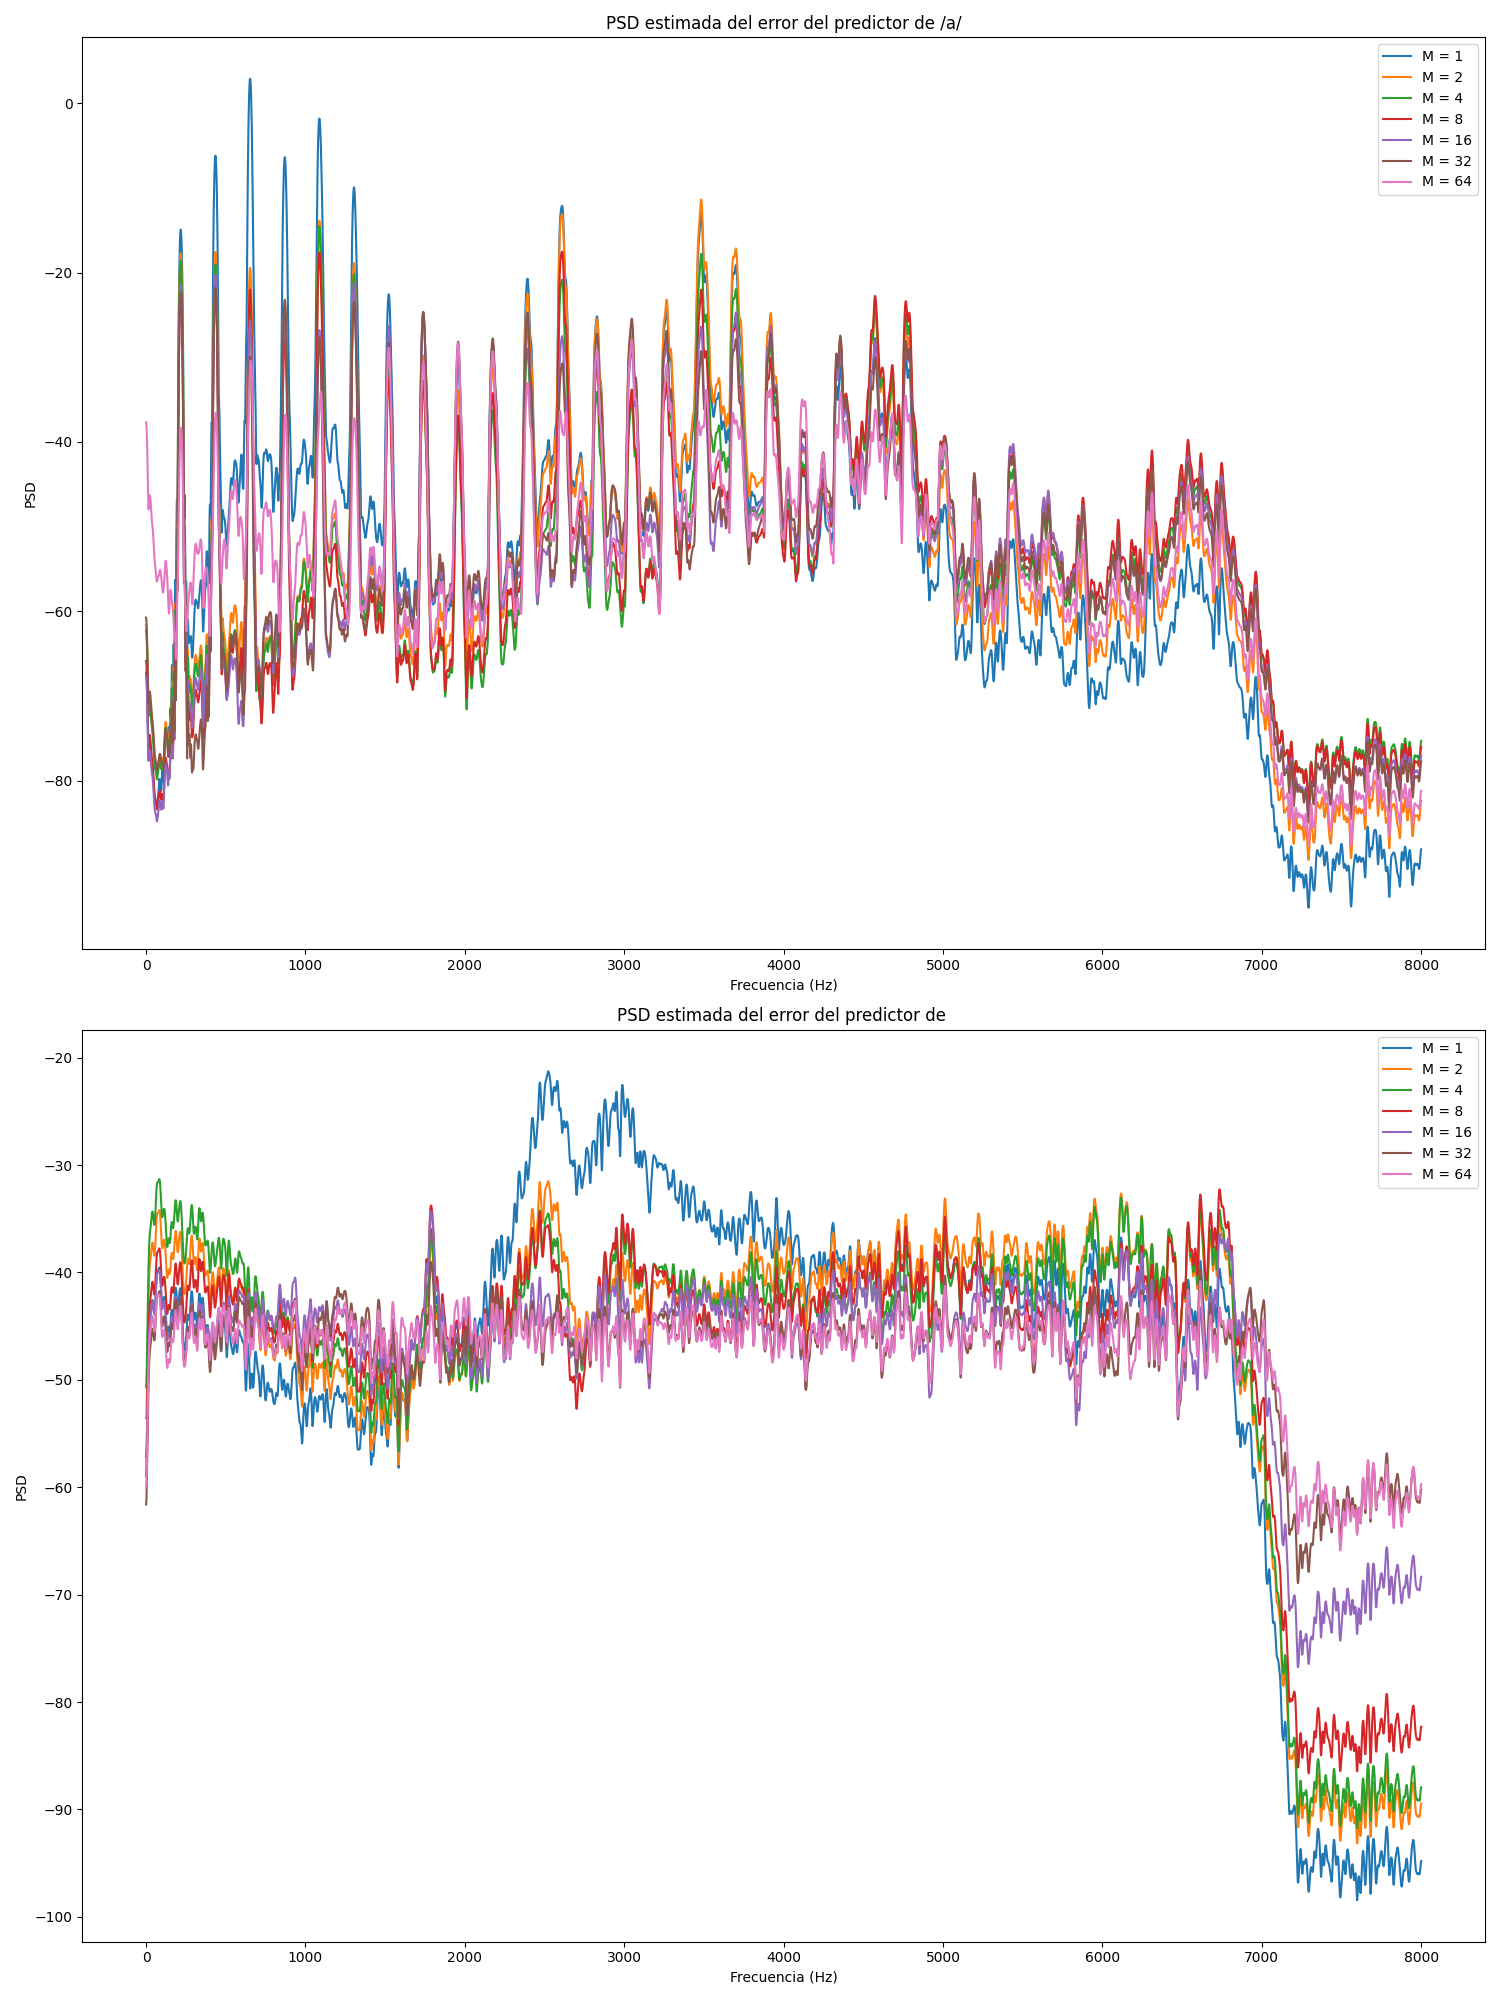

In [27]:
plt.figure(tight_layout=True, figsize=(15, 20))
plt.subplot(211)


for i in np.logspace(0, 6, 7, endpoint=True, base=2, dtype=int):
    err_fa = sp.lfilter(a_a[i-1], [1], signal['a']) 
    freq, psd, L = hp.periodogram_averaging(err_fa, fss['a'], len(err_fa)//10, 8, lambda N: sp.get_window('hann', N))
    A = 10*np.log10(psd+1e-18)
    plt.plot(freq, A, label=f'M = {i}')

plt.title("PSD estimada del error del predictor de /a/")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("PSD")
plt.legend()

plt.subplot(212)
for i in np.logspace(0, 6, 7, endpoint=True, base=2, dtype=int):
    err_fsh = sp.lfilter(a_sh[i-1], [1], signal['sh'])
    freq, psd, L = hp.periodogram_averaging(err_fsh, fss['sh'], len(err_fsh)//10, 8, lambda N: sp.get_window('hann', N))
    A = 10*np.log10(psd+1e-18)
    plt.plot(freq, A, label=f'M = {i}')
    

plt.title("PSD estimada del error del predictor de ")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("PSD")
plt.legend()

# $\textit{4)}$

En el caso de la /a/, como se vio que el filtro para un orden del primer codo no logra una señal error blanca, se decidio sintetizar un modelo de error AR. Este modelo AR se tomo de un orden p = 90, que se encuentra luego del 2do codo esperando que con esto se pueda lograr modelar esas correlaciones y obtener un buen resultado de sintesis. Esto se pudo comprobar empiricamente si se escucha a la señal original y se la compara con la sintetizada con el error modelado con AR. En comparacion con un error Gaussiano, el AR genera un /a/ sintetizado mucho mas similar al original, en comparacion con el gaussiano que genera un sonido mucho mas cercano a ruido que a /a/.

Para el caso de /sh/, como se observo que el espectro de salida era plano (por lo menos hasta 7000Hz que corresponde con el ancho de banda de la señal de entrada), se utilizo un error modelado por un ruido gaussiano, que dio resultados favorables si se comparan ambas señales de forma perceptual a traves de la escucha.

In [14]:
Ma = 16
Msh = 20

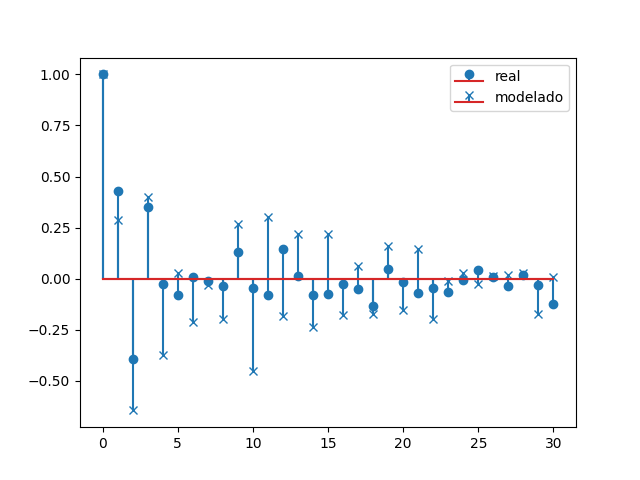

In [16]:
plt.figure()
# Generamos una estimacion del modelo AR que ajusta al error
model = AutoReg(err_fa, 90)
results = model.fit()
coeffs = results.params
#
# Plot the prediction vs test data
#
err_sint = np.random.normal(0, 0.01, fss["a"]*1)
err_sint2 = sp.lfilter([1], np.concatenate((np.array([1]), -coeffs[1:])), err_sint)

plt.stem(pacf(err_fa, 30), label='real')
plt.stem(pacf(err_sint2, 30), label='modelado', markerfmt='x')
plt.legend()

In [17]:
out = sp.lfilter([1], a_a[Ma], err_sint)
out2 = sp.lfilter([1], a_a[Ma], err_sint2)

display('Original:' , Audio(data=signal['a'], rate=fss["a"]))
display('Error gaussiano:' , Audio(data=out, rate=fss["a"]))
display('Error AR:' ,Audio(data=out2, rate=fss["a"]))


'Original:'

'Error gaussiano:'

'Error AR:'

In [18]:
err_sint = np.random.normal(0, 0.01, fss["sh"]*2)
out = sp.lfilter([1], a_sh[Msh], err_sint)

display('Original:' , Audio(data=signal['sh'], rate=fss["sh"]))
display('Error gaussiano:' , Audio(data=out, rate=fss["sh"]))

'Original:'

'Error gaussiano:'

# $\textit{5)}$

Lo que se esperaba de esta prueba era poder sintetizar nuevamente un fragmento de voz a traves del modelado de predictores optimos para fragmentos de 50ms (800 muestras). Si se asume que estos fragmentos son localmente estacionarios, el filtro del error de predicion optimo converge a un filtro blanqueador. Al aplicar la inversa de este filtro a un tren de deltas de 160 Hz (5 deltas por bloque)

In [19]:
fsfrase, frase = io.wavfile.read("recFrase1.wav")
L = 800
overlap = 400
hann_window = sp.get_window('hann', L)
splitted_frase = np.array([frase[i*overlap : i*overlap + L]*hann_window for i in range(0, len(frase)//overlap-1)])
print(splitted_frase.shape)

(351, 800)


/tmp/ipykernel_18096/2626088955.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, frase = io.wavfile.read("recFrase1.wav")


In [20]:
M = 12
fimpulse = 160
slen = len(splitted_frase)
wos = np.zeros((slen, M))
coefs = np.zeros((slen, M+1))
jos = np.zeros(slen)

for i in range(slen):
    #Realizamos la prediccion forward
    wo, jo, NMSE = hp.get_optimal_params(splitted_frase[i], M)
    jos[i] = jo
    coefs[i] = np.insert(-wo, 0, 1) 
    wos[i] = wo

impulsos = sp.unit_impulse(len(frase), [np.arange(0, len(frase) + 1, fsfrase//fimpulse)])
splitted_impulse = np.array([impulsos[i*overlap : i*overlap + L] for i in range(0, len(impulsos)//overlap-1)])
print(splitted_impulse.shape)

(351, 800)


In [21]:
results = np.zeros(overlap*(slen+1))

for i, coeffs in enumerate(coefs):
    results[i*overlap : i*overlap + L] += sp.lfilter([1], coeffs, splitted_impulse[i])*hann_window

display(Audio(data=results, rate=fsfrase))
display(Audio(data=frase, rate=fsfrase))
io.wavfile.write(data=results, rate=fsfrase, filename='frase_reversed.wav')